# 1. Import Required Libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# 2. Load and Preprocess Dataset 

In [2]:
# Load the dataset from Excel file
df_real = pd.read_excel("data.xlsx") 

# Standardize the real data (zero mean, unit variance)
scaler = StandardScaler()
real_data = scaler.fit_transform(df_real.values).astype(np.float32)

# 3. Create DataLoader for Batching

In [3]:
# Convert real data to PyTorch tensor
real_tensor = torch.tensor(real_data)

# Wrap tensor in a TensorDataset and create DataLoader
batch_size = 64
dataset = TensorDataset(real_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 4. Define Generator and Critic Models for WGAN

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),   # Project noise vector to hidden layer
            nn.ReLU(),                   # Activation function
            nn.Linear(128, 128),         # Hidden layer
            nn.ReLU(),                   # Activation function
            nn.Linear(128, output_dim),  # Output layer mapping to data dimension
        )

    def forward(self, z):
        return self.model(z)             # Forward pass of the generator


class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),     # Input projection
            nn.LayerNorm(128),             # Normalize to stabilize training
            nn.LeakyReLU(0.2),             # Activation with slight negative slope
            nn.Linear(128, 128),           # Hidden layer
            nn.LayerNorm(128),             # Normalize again
            nn.LeakyReLU(0.2),             # Activation
            nn.Linear(128, 1),             # Output single critic score
        )

    def forward(self, x):
        return self.model(x)               # Forward pass of the critic


# 5. Define Gradient Penalty Function (for WGAN-GP)

In [5]:
def gradient_penalty(critic, real_samples, fake_samples):
    # Random weight term for interpolation between real and fake samples
    epsilon = torch.rand(real_samples.size(0), 1)
    epsilon = epsilon.expand_as(real_samples)

    # Interpolate between real and fake samples
    interpolated = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolated.requires_grad_(True)  # Enable gradient computation

    # Compute critic scores on the interpolated samples
    critic_scores = critic(interpolated)

    # Compute gradients of the scores w.r.t. the interpolated inputs
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_scores),  # Backprop for each score
        create_graph=True,  # Needed for higher-order gradients
        retain_graph=True,
        only_inputs=True
    )[0]

    # Flatten gradients and compute the L2 norm for each sample
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # Gradient penalty term

    return gp


# 6. WGAN-GP Training Loop (With Generator & Critic Updates)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 16  # Dimensionality of the input noise vector
gen = Generator(noise_dim, real_data.shape[1]).to(device)
critic = Critic(real_data.shape[1]).to(device)

lr = 1e-4
lambda_gp = 10    # Weight for gradient penalty term
n_critic = 5      # Number of critic updates per generator update

# Adam optimizers with β1 = 0.0, β2 = 0.9 as recommended in WGAN-GP paper
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

for epoch in range(1000):  # Total number of epochs
    for i, (real_batch,) in enumerate(dataloader):
        real_batch = real_batch.to(device)
        batch_size = real_batch.size(0)

        for _ in range(n_critic):
            # Sample noise and generate fake data
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_batch = gen(z).detach()  # Detach so gradients don’t flow to generator

            # Compute critic scores for real and fake samples
            real_score = critic(real_batch)
            fake_score = critic(fake_batch)

            # Calculate gradient penalty
            gp = gradient_penalty(critic, real_batch, fake_batch)

            # Compute total critic loss
            loss_critic = -(real_score.mean() - fake_score.mean()) + lambda_gp * gp

            # Backprop and update critic
            opt_critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

        z = torch.randn(batch_size, noise_dim).to(device)
        gen_samples = gen(z)

        # Generator wants the critic to think the fake samples are real
        loss_gen = -critic(gen_samples).mean()

        # Backprop and update generator
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Critic Loss: {loss_critic.item():.4f} | Gen Loss: {loss_gen.item():.4f}")


Epoch 0 | Critic Loss: -1.0552 | Gen Loss: 2.0429
Epoch 50 | Critic Loss: -0.1488 | Gen Loss: 5.1040
Epoch 100 | Critic Loss: -0.2895 | Gen Loss: 6.4490
Epoch 150 | Critic Loss: -0.1040 | Gen Loss: 7.1195
Epoch 200 | Critic Loss: -0.5279 | Gen Loss: 7.0715
Epoch 250 | Critic Loss: -0.2709 | Gen Loss: 7.4399
Epoch 300 | Critic Loss: -0.2855 | Gen Loss: 8.0431
Epoch 350 | Critic Loss: 0.0356 | Gen Loss: 8.4019
Epoch 400 | Critic Loss: -0.2649 | Gen Loss: 9.0398
Epoch 450 | Critic Loss: -0.1336 | Gen Loss: 9.7943
Epoch 500 | Critic Loss: -0.2392 | Gen Loss: 9.8442
Epoch 550 | Critic Loss: -0.5075 | Gen Loss: 10.5382
Epoch 600 | Critic Loss: -0.2292 | Gen Loss: 11.3643
Epoch 650 | Critic Loss: -0.4439 | Gen Loss: 12.2127
Epoch 700 | Critic Loss: -0.1211 | Gen Loss: 13.0929
Epoch 750 | Critic Loss: -0.1401 | Gen Loss: 14.1265
Epoch 800 | Critic Loss: -0.3165 | Gen Loss: 14.9299
Epoch 850 | Critic Loss: -0.9189 | Gen Loss: 15.4940
Epoch 900 | Critic Loss: -0.1308 | Gen Loss: 16.3727
Epoch 95

# 7. Generate Synthetic Data from Trained Generator

In [7]:
gen.eval()  # Set generator to evaluation mode (disables dropout/batchnorm if any)

with torch.no_grad():  # No need to track gradients during inference
    # Generate noise vectors equal to the number of real samples
    z = torch.randn(len(real_data), noise_dim).to(device)

    # Generate synthetic data using the trained generator
    synthetic_data = gen(z).cpu().numpy()

    # Inverse transform to original scale (undo standardization)
    synthetic_data = scaler.inverse_transform(synthetic_data)

# Convert synthetic data to DataFrame with same column names as real data
df_fake = pd.DataFrame(synthetic_data, columns=df_real.columns)

# 8. Plotting Feature Distributions — Real vs. Synthetic

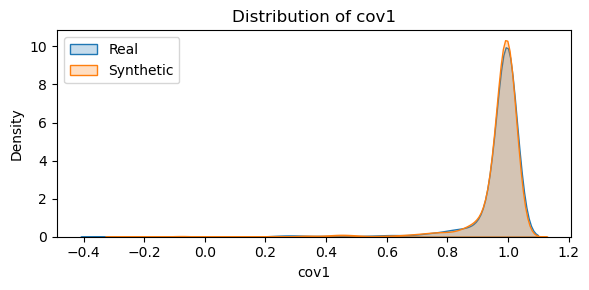

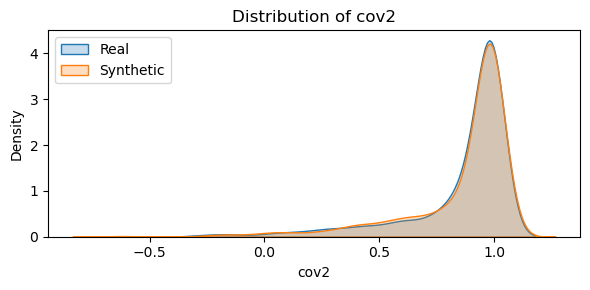

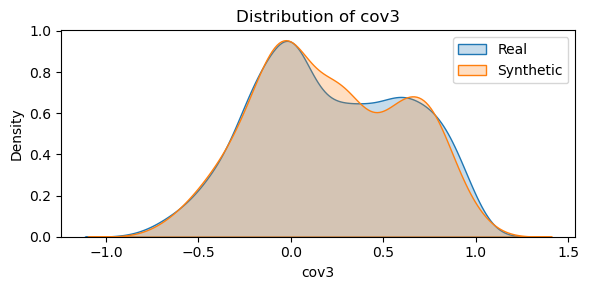

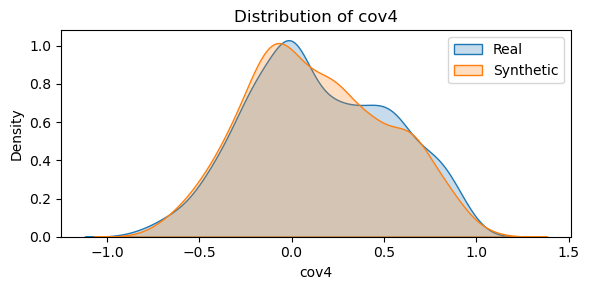

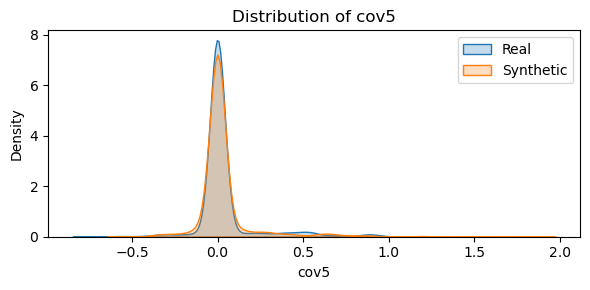

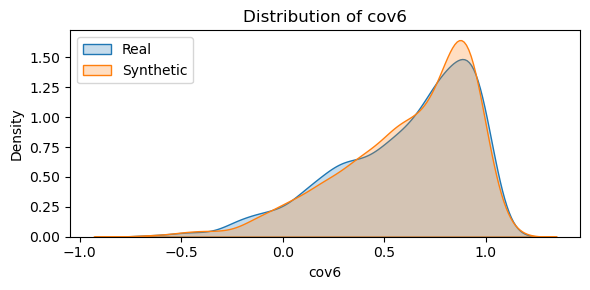

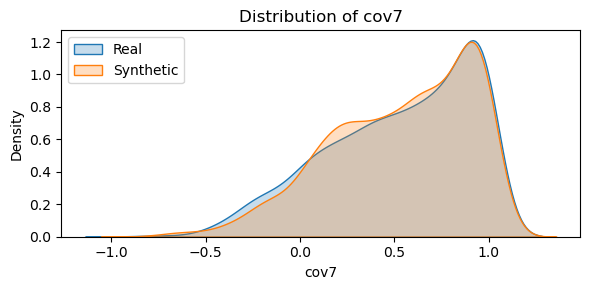

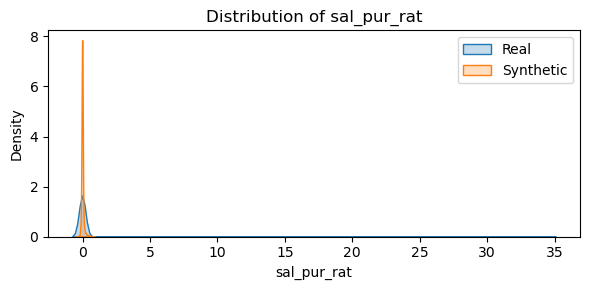

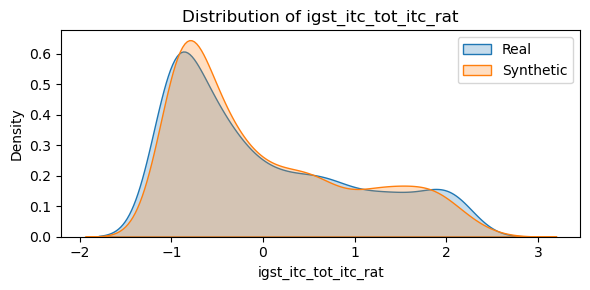

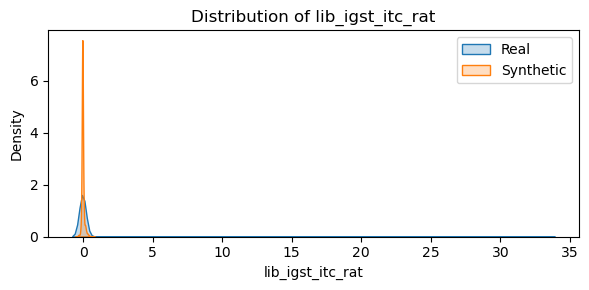

In [8]:
import matplotlib.pyplot as plt

# Loop through each feature column
for col in df_real.columns:
    plt.figure(figsize=(6, 3))  # Set plot size

    # Plot KDE for real data
    sns.kdeplot(df_real[col], label='Real', fill=True)

    # Plot KDE for synthetic data
    sns.kdeplot(df_fake[col], label='Synthetic', fill=True)

    # Plot formatting
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 9. Heatmap of Feature Correlations — Real vs. Synthetic

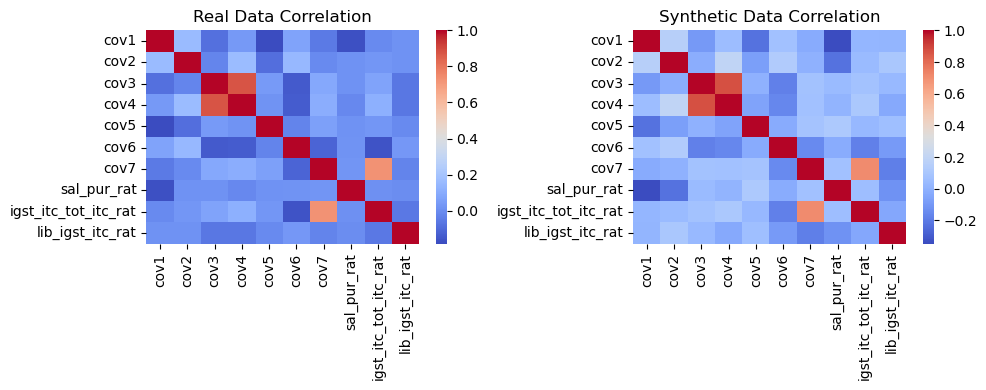

In [9]:
# Compute pairwise Pearson correlation matrices
real_corr = df_real.corr()
fake_corr = df_fake.corr()

# Plot the heatmaps side by side
plt.figure(figsize=(10, 4))

# --- Real Data Heatmap ---
plt.subplot(1, 2, 1)
sns.heatmap(real_corr, cmap='coolwarm', annot=False)
plt.title("Real Data Correlation")

# --- Synthetic Data Heatmap ---
plt.subplot(1, 2, 2)
sns.heatmap(fake_corr, cmap='coolwarm', annot=False)
plt.title("Synthetic Data Correlation")

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.signal import correlate2d
# Calculate metrics to compare the real and synthetic correlation matrices

# 1. **Mean Squared Error (MSE) between the correlation matrices**
mse = mean_squared_error(real_corr.values.flatten(), fake_corr.values.flatten())
print(f"Mean Squared Error between real and synthetic correlation matrices: {mse}")

# 2. **Correlation Coefficient between real and synthetic correlation matrices**
correlation_matrix = np.corrcoef(real_corr.values.flatten(), fake_corr.values.flatten())
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation coefficient between real and synthetic correlation matrices: {correlation}")

# 3. **Structural Similarity Index (SSIM) using scipy**
def ssim_matrix(x, y):
    return np.sum(correlate2d(x, y, mode='valid')) / np.sqrt(np.sum(x**2) * np.sum(y**2))

# Compute SSIM between the two correlation matrices
ssim_value = ssim_matrix(real_corr.values, fake_corr.values)
print(f"Structural Similarity Index (SSIM) between real and synthetic correlation matrices: {ssim_value}")

# Optionally, you can also print out some other metrics like the sum or mean of the correlation matrices.
print(f"Mean of real correlation matrix: {real_corr.mean().mean()}")
print(f"Mean of synthetic correlation matrix: {fake_corr.mean().mean()}")

Mean Squared Error between real and synthetic correlation matrices: 0.004119192862999663
Pearson correlation coefficient between real and synthetic correlation matrices: 0.9836771100611224
Structural Similarity Index (SSIM) between real and synthetic correlation matrices: 0.9848362385044007
Mean of real correlation matrix: 0.12934598077858378
Mean of synthetic correlation matrix: 0.11859095712421788
